In [2]:
#default_exp cg

In [1]:
#export
import local.operators as operators
import inspect
import math
class UnknownCGVar(Exception): pass
class NeverInitializedGcInput(Exception): pass
class BadlyNamedGcVar(Exception): pass
class PlaceHolderCGVal(): pass
class CGVar():
    def __init__(self,name:str, f = lambda:None,val = PlaceHolderCGVal(),is_input = False, deps : list = [],initialStep = 0):
        self.name = name
        self.f = f
        self.opt : bool = False
        self.deps : list = []
        self.str_deps : list= deps
        self.in_deps : list = []
        self._step_counter : int = initialStep
        self.val = val
        self.has_changed : bool = True
        self.is_input = is_input
    def setVal(self,val):
        if val != self.val:
            self.val = val
            self.is_input = True
            self.has_changed = True
    def run(self, CG):
        if self._step_counter < CG._step_counter : 
            self._step_counter += CG._step_counter
            if self.is_input:
                if not self.has_changed and type(self.val) == PlaceHolderCGVal : raise NeverInitializedGcInput(f"'{name}' has never been initialized in this graph")
                self.has_changed = False
            else:
                if not self.opt : self._run_unopt(CG)
                else: self._run_opt(CG)
        
        if self.is_input : return (self.val, [self])
        else :  return (self.val, self.in_deps) 
    def _run_unopt(self,CG):
        self.in_deps = []
        self.deps = []
        rets=[]
        for dep in self.str_deps:
            try : dep = CG._vars[dep]
            except KeyError : raise UnknownCGVar(f"'{name}' has never been declared in this graph")
            self.deps.append(dep)
            ret, in_dep = dep.run(CG)
            rets.append(ret)
            self.in_deps.extend(in_dep)
        self.opt = True
        self.val = self.f(*rets)
    def _run_opt(self,CG):
        rets = []
        needRecompute = False
        for in_dep in self.in_deps : needRecompute = (needRecompute or in_dep.has_changed)
        if not needRecompute: self.has_changed = False
        else:
            for dep in self.deps: rets.append(dep.run(CG)[0])
            oldval = self.val
            self.val = self.f(*rets)
            self.has_changed = (oldval != self.val)
    def __repr__(self):
        if self.is_input :
            ret = str(self.name) +"[label=\"" + str(self.name) + "\"]"
        else:
            ret = str(self.name) +"[label=\"" + str(self.name) + f" = f({', '.join(self.str_deps)})\"]"
            for dep in self.str_deps:
                ret +="\n" + dep + "->" + str(self.name) + f'[color="{"red" if hasattr(self.f, "_observes") and self.f._observes else "green"}"]'
        return ret 

    
    
    
    
class ComputeGraph():
    def __init__(self, name = "DAG", autostep = True):
        self._name = name
        self._autostep = autostep
        self._observers : list = list()
        self._step_counter : int = 0
        self._vars : dict = dict()
    def __getattr__(self,name):
        try : return self._vars[name].run(CG = self)[0]
        except KeyError : raise UnknownCGVar(f"'{name}' has never been declared in this graph")
    def add(self, f, name:str = None):
        if name == None: 
            name = f.__name__
        for v in self._vars.values(): v.opt = False
        deps = f._args if hasattr(f, "_args") else inspect.getfullargspec(f)[0]
        self._vars[name] =  CGVar(name, f, deps=deps, initialStep = self._step_counter)
        for dep_name in deps:
            if dep_name not in self._vars.keys():
                self._vars[dep_name]=CGVar(dep_name, is_input=True)
        if hasattr(f, "_observes") and f._observes : self._observers.append(self._vars[name])
    def setIn(self,**kwargs):
        for k,v in kwargs.items():
            try : self._vars[k].setVal(v)
            except KeyError : 
                self.check_names(self,k)
                for v in self._vars.values(): v.opt = False
                self._vars[k] = CGVar(name=k, val=v, is_input=True)
        if self._autostep : 
            self.makeStep()        
    def _check_names(self,namelist):
        _banned_name = []
        _banned_name = dir(self)
        for name in namelist:
            if name in banned_names : raise BadlyNamedGcVar(f"one of your graph var is called '{name}' ..."+
                                                        "\n It is currently not authorised with this library")
    def makeStep(self):
        self._step_counter +=1
        for obs in self._observers:
            obs.run(CG = self)
        
    def __repr__(self):
        ret = 'digraph '  + self._name +" {"
        for k,var in self._vars.items():
            ret += '\n' + str(var.__repr__())
        ret += "\n}"
        return ret

In [7]:


def B(t,c,d):
    return math.cos(t)+c-(d*t)

g = ComputeGraph()
g.add(B)#created a var B that depends on t,c and d using the above function
g.add(operators.Add("B A"),"AplusB")
g.add(lambda A,B: A+B, "addAB")#created a var 'addAB' that depends on A and B using a lambda
g.add(lambda t: math.cos(t),"A")
g.add(operators.Avg("B"))#created a var 'Avg_B' using operators
g.add(operators.Exp_avg("addAB"), "foo")


['B', 'A']
['B']
['addAB']


In [8]:
g


digraph DAG {
B[label="B = f(t, c, d)"]
t->B[color="green"]
c->B[color="green"]
d->B[color="green"]
t[label="t"]
c[label="c"]
d[label="d"]
AplusB[label="AplusB = f(B, A)"]
B->AplusB[color="green"]
A->AplusB[color="green"]
A[label="A = f(t)"]
t->A[color="green"]
addAB[label="addAB = f(A, B)"]
A->addAB[color="green"]
B->addAB[color="green"]
Avg_B[label="Avg_B = f(B)"]
B->Avg_B[color="red"]
foo[label="foo = f(addAB)"]
addAB->foo[color="red"]
}

In [24]:
count = 0
for i in range(50):
    count += i
    g.setIn(t=i,c=3, d=4)



In [26]:
g.Avg_d

4.0

In [55]:

avg = g._vars["Avg_t"]
#count/50

In [4]:
'A B'.split()

['A', 'B']

In [47]:
g._vars["A"]._step_counter

0

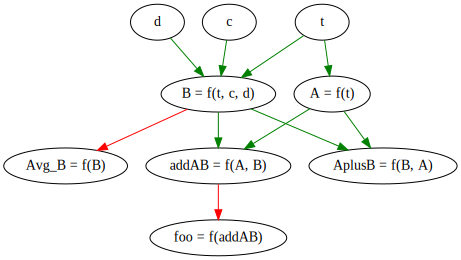

In [9]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
graph = Source(g)
display(SVG(graph.pipe(format='svg')))

In [4]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_utils.ipynb.
Converted 02_script.ipynb.
Converted 90_notebook_core.ipynb.
Converted 91_notebook_export.ipynb.
Converted 93_notebook_export2html.ipynb.
Converted 94_notebook_test.ipynb.
Converted 95_index.ipynb.
Converted 96_data_external.ipynb.
Converted 97_utils_test.ipynb.
Converted GC.ipynb.
This cell doesn't have an export destination and was ignored:
e
Converted Operators.ipynb.
